In [1]:


import lettuce as lt
from lettuce import D3Q19, Lattice, UnitConversion
import csv

In [2]:

class WallQuantitiesInternal:
    def __init__(
        self,
        lattice,
        flow,
        molecular_viscosity,
        y_lattice=1.0,
        wall='bottom',
        kappa=0.41,
        B=5.2,
        max_iter=100,
        tol=1e-8,
        use_smagorinsky=False,
        smagorinsky_collision_instance=None
    ):
        self.lattice = lattice
        self.flow = flow
        self.nu = molecular_viscosity
        self.y = y_lattice
        self.wall = wall
        self.kappa = kappa
        self.B = B
        self.max_iter = max_iter
        self.tol = tol
        self.normal_axis = 1  # y-Achse

        self.use_smagorinsky = use_smagorinsky
        if self.use_smagorinsky:
            if smagorinsky_collision_instance is None:
                raise ValueError("Smagorinsky collision instance required if use_smagorinsky=True.")
            self.smagorinsky_collision = smagorinsky_collision_instance

    def spalding_law(self, y_plus_grid_dist, u_mag_wall_parallel, nu_effective):
        y_plus_grid_dist = torch.tensor(y_plus_grid_dist, device=u_mag_wall_parallel.device, dtype=u_mag_wall_parallel.dtype)
        u_plus = (y_plus_grid_dist * u_mag_wall_parallel / nu_effective).clamp(min=1e-4).detach().clone().requires_grad_(False)

        for _ in range(self.max_iter):
            ku = self.kappa * u_plus
            exp_ku = torch.exp(ku)
            spalding_term = u_plus + torch.exp(torch.tensor(-self.kappa * self.B, device=u_plus.device, dtype=u_plus.dtype)) * (
                exp_ku - 1 - ku - 0.5 * ku**2 - (1/6) * ku**3
            )
            rhs = (y_plus_grid_dist * u_mag_wall_parallel) / (nu_effective * u_plus.clamp(min=1e-8))
            f_eq_solve = spalding_term - rhs

            d_spalding_term = 1 + torch.exp(torch.tensor(-self.kappa * self.B, device=u_plus.device, dtype=u_plus.dtype)) * (
                self.kappa * exp_ku - self.kappa - self.kappa**2 * u_plus - 0.5 * self.kappa**3 * u_plus**2
            )
            d_rhs = - (y_plus_grid_dist * u_mag_wall_parallel) / (nu_effective * u_plus.clamp(min=1e-8)**2)
            df_eq_solve = d_spalding_term - d_rhs

            delta = f_eq_solve / torch.where(torch.abs(df_eq_solve) < 1e-10, torch.tensor(1e-10, device=f_eq_solve.device), df_eq_solve)
            u_plus = (u_plus - delta).clamp(min=1e-4)

            if torch.max(torch.abs(delta)) < self.tol:
                break
        return u_plus

    def __call__(self, f_full_grid):
        rho_full = self.lattice.rho(f_full_grid)
        u_full = self.lattice.u(f_full_grid)

        if rho_full.ndim == self.lattice.D + 1 and rho_full.shape[0] == 1:
            rho_full = rho_full.squeeze(0)
        if u_full.ndim == self.lattice.D + 1 and u_full.shape[1] == 1:
            u_full = u_full.squeeze(1)

        grid_spatial_dims = list(range(self.lattice.D))
        spatial_idx_slice = [slice(None)] * self.lattice.D
        spatial_idx_slice[self.normal_axis] = 1 if self.wall == "bottom" else -2

        rho_f = rho_full[tuple(spatial_idx_slice)].flatten()
        u_x_f = u_full[0][tuple(spatial_idx_slice)].flatten()
        u_y_f = u_full[1][tuple(spatial_idx_slice)].flatten()
        u_z_f = u_full[2][tuple(spatial_idx_slice)].flatten() if self.lattice.D == 3 else torch.zeros_like(u_x_f)

        u_mag_wall_parallel = torch.sqrt(u_x_f**2 + u_z_f**2).clamp(min=1e-10)

        if self.use_smagorinsky:
            tau_eff_scalar = self.smagorinsky_collision.tau_eff
            shape = u_full[0].shape
            tau_eff_full_grid = torch.full(shape, tau_eff_scalar, device=u_full.device, dtype=u_full.dtype)
            nu_eff_full_grid = (tau_eff_full_grid - 0.5) / 3.0
            nu_eff_wall_layer = nu_eff_full_grid[tuple(spatial_idx_slice)].flatten()
        else:
            nu_eff_wall_layer = torch.full_like(u_mag_wall_parallel, self.nu)

        u_plus = self.spalding_law(self.y, u_mag_wall_parallel, nu_eff_wall_layer)
        u_tau = (u_mag_wall_parallel / u_plus).clamp(min=1e-8)
        tau_w = rho_f * u_tau**2

        safe_u_mag = torch.where(u_mag_wall_parallel < 1e-10, torch.tensor(1.0, device=u_mag_wall_parallel.device, dtype=u_mag_wall_parallel.dtype), u_mag_wall_parallel)
        tau_x = - (u_x_f / safe_u_mag) * tau_w
        tau_z = - (u_z_f / safe_u_mag) * tau_w

        tau_x_wall = torch.zeros_like(u_full[0])
        tau_z_wall = torch.zeros_like(u_full[2] if self.lattice.D == 3 else u_full[0])

        if self.lattice.D == 3:
            target_shape_slice = tau_x_wall[tuple(spatial_idx_slice)].shape
            tau_x_wall[tuple(spatial_idx_slice)] = tau_x.reshape(target_shape_slice)
            tau_z_wall[tuple(spatial_idx_slice)] = tau_z.reshape(target_shape_slice)
        else:
            raise ValueError("Only 3D supported for this current implementation of WallQuantitiesInternal.")

        return {
            "tau_x": tau_x_wall,
            "tau_z": tau_z_wall,
            "u_tau": u_tau
        }


In [3]:
class WallFunctionBoundaryTest:
    def __init__(self, mask, lattice, flow, wall='bottom',
                 kappa=0.41, B=5.2, max_iter=100, tol=1e-8):
        self.mask = lattice.convert_to_tensor(mask)
        self.lattice = lattice
        self.flow = flow
        self.wall = wall
        self.kappa = kappa
        self.B = B
        self.max_iter = max_iter
        self.tol = tol

        self.tau_x = None
        self.tau_z = None

        self.u_tau_mean = torch.tensor(0.0, device=lattice.device, dtype=lattice.dtype)
        self.y_plus_mean = torch.tensor(0.0, device=lattice.device, dtype=lattice.dtype)
        self.Re_tau_mean = torch.tensor(0.0, device=lattice.device, dtype=lattice.dtype)
        self.previous_u_tau_mean = torch.tensor(0.0, device=lattice.device, dtype=lattice.dtype)

    def solve_u_tau_exact(self, y, u, nu):
        device = u.device
        dtype = u.dtype
        kappa = self.kappa
        B = self.B
        A = torch.exp(torch.tensor(-kappa * B, device=device, dtype=dtype))

        u_tau = u.clone().clamp(min=1e-4)

        for _ in range(self.max_iter):
            u_plus = u / u_tau
            ku = kappa * u_plus
            exp_ku = torch.exp(ku)

            f_rhs = u_plus + A * (exp_ku - 1 - ku - 0.5 * ku ** 2 - (1 / 6) * ku ** 3)
            lhs = y * u_tau / nu
            residual = lhs - f_rhs

            d_f_rhs_duplus = 1 + A * (kappa * exp_ku - kappa - kappa**2 * u_plus - 0.5 * kappa**3 * u_plus**2)
            d_uplus_du_tau = -u / u_tau**2
            df_du_tau = d_f_rhs_duplus * d_uplus_du_tau

            d_lhs_du_tau = y / nu
            total_derivative = d_lhs_du_tau - df_du_tau

            safe_deriv = torch.where(torch.abs(total_derivative) < 1e-12,
                                     torch.tensor(1e-12, device=device, dtype=dtype),
                                     total_derivative)

            delta = residual / safe_deriv
            u_tau_new = (u_tau - delta).clamp(min=1e-5)

            if torch.max(torch.abs(delta)) < self.tol:
                break

            u_tau = u_tau_new

        return u_tau

    def __call__(self, f):
        if self.wall == 'bottom':
            f17_old = f[17, self.mask].clone()
            f16_old = f[16, self.mask].clone()
            f10_old = f[10, self.mask].clone()
            f8_old  = f[8, self.mask].clone()

        elif self.wall == 'top':
            f15_old = f[15, self.mask].clone()
            f18_old = f[18, self.mask].clone()
            f7_old  = f[7, self.mask].clone()
            f9_old  = f[9, self.mask].clone()
        else:
            raise ValueError("wall must be 'bottom' or 'top'")



        rho = self.lattice.rho(f)
        rho = rho[:,self.mask]
        u = self.lattice.u(f)

        u_x = u[0][self.mask]
        u_z = u[2][self.mask]
        u_mag_parallel = torch.sqrt(u_x**2 + u_z**2).clamp(min=1e-10)

        y = torch.tensor(1.0, device=f.device, dtype=f.dtype)
        nu = torch.tensor(self.flow.units.viscosity_lu, device=f.device, dtype=f.dtype)

        if nu <= 0 or torch.isnan(nu) or torch.isinf(nu):
            self.previous_u_tau_mean = self.u_tau_mean.clone().detach()
            self.u_tau_mean = torch.tensor(0.0, device=f.device, dtype=f.dtype)
            self.y_plus_mean = torch.tensor(0.0, device=f.device, dtype=f.dtype)
            self.Re_tau_mean = torch.tensor(0.0, device=f.device, dtype=f.dtype)
            return f

        u_tau = self.solve_u_tau_exact(y, u_mag_parallel, nu)
        tau_w = rho * u_tau**2

        if torch.isnan(tau_w).any() or torch.isinf(tau_w).any():
            self.previous_u_tau_mean = self.u_tau_mean.clone().detach()
            self.u_tau_mean = torch.tensor(0.0, device=f.device, dtype=f.dtype)
            self.y_plus_mean = torch.tensor(0.0, device=f.device, dtype=f.dtype)
            self.Re_tau_mean = torch.tensor(0.0, device=f.device, dtype=f.dtype)
            return f

        safe_u = torch.where(u_mag_parallel < 1e-10, torch.tensor(1.0, device=f.device), u_mag_parallel)
        tau_x = - (u_x / safe_u) * tau_w
        tau_z = - (u_z / safe_u) * tau_w

        tau_x_field = torch.zeros_like(u[0])
        tau_z_field = torch.zeros_like(u[2] if self.lattice.D == 3 else u[0])
        tau_x_field[self.mask] = tau_x
        tau_z_field[self.mask] = tau_z

        f = torch.where(self.mask, f[self.lattice.stencil.opposite], f)

        if self.wall == 'bottom':
            f[15, self.mask] = f17_old + tau_z_field[self.mask]
            f[16, self.mask] = f17_old + tau_z_field[self.mask]
            f[18, self.mask] = f16_old - tau_z_field[self.mask]
            f[8,  self.mask] = f16_old - tau_z_field[self.mask]
            f[7,  self.mask] = f10_old + tau_x_field[self.mask]
            f[17, self.mask] = f10_old + tau_x_field[self.mask]
            f[9,  self.mask] = f8_old - tau_x_field[self.mask]
            f[10, self.mask] = f8_old - tau_x_field[self.mask]
        elif self.wall == 'top':
            f[17, self.mask] = f15_old + tau_z_field[self.mask]
            f[18, self.mask] = f15_old + tau_z_field[self.mask]
            f[16, self.mask] = f18_old - tau_z_field[self.mask]
            f[9,  self.mask] = f18_old - tau_z_field[self.mask]
            f[10, self.mask] = f7_old + tau_x_field[self.mask]
            f[15, self.mask] = f7_old + tau_x_field[self.mask]
            f[8,  self.mask] = f9_old - tau_x_field[self.mask]
            f[7,  self.mask] = f9_old - tau_x_field[self.mask]

        self.tau_x = tau_x_field
        self.tau_z = tau_z_field
        self.previous_u_tau_mean = self.u_tau_mean.clone().detach()
        self.u_tau_mean = u_tau.mean()
        # Lokales y_plus wie gehabt
        self.y_plus_mean = (y * u_tau / nu).mean()

        # Korrektes Re_tau
        H = self.flow.resolution_y / 2  # für y-Achse
        self.Re_tau_mean = (u_tau * H / nu).mean()

        print("Re tau:" + str(self.Re_tau_mean))
        if torch.isnan(self.u_tau_mean) or torch.isinf(self.u_tau_mean) or \
           torch.isnan(self.y_plus_mean) or torch.isinf(self.y_plus_mean) or \
           torch.isnan(self.Re_tau_mean) or torch.isinf(self.Re_tau_mean):
            self.u_tau_mean = torch.tensor(0.0, device=f.device, dtype=f.dtype)
            self.y_plus_mean = torch.tensor(0.0, device=f.device, dtype=f.dtype)
            self.Re_tau_mean = torch.tensor(0.0, device=f.device, dtype=f.dtype)


        return f

    def make_no_collision_mask(self, f_shape):
        assert self.mask.shape == f_shape[1:]
        return self.mask


In [4]:
class WallFunctionBoundaryTest2:
    def __init__(self, mask, lattice, flow, wall='bottom', apply_wfb_correction=True,
                 smagorinsky_collision_instance=None):
        self.mask = lattice.convert_to_tensor(mask)
        self.lattice = lattice
        self.flow = flow
        self.wall = wall
        self.apply_wfb_correction = apply_wfb_correction
        self.normal_axis = 1

        self.tau_x = None
        self.tau_z = None
        self.u_tau_mean = None
        self.y_plus_mean = None
        self.Re_tau_mean = None

        self.use_smagorinsky = smagorinsky_collision_instance is not None

        # Konstruktion der WallQuantitiesInternal – immer
        self.wall_quantities_internal = WallQuantitiesInternal(
            lattice=self.lattice,
            flow=self.flow,
            molecular_viscosity=self.flow.units.viscosity_lu,
            wall=self.wall,
            y_lattice=1.0,
            use_smagorinsky=self.use_smagorinsky,
            smagorinsky_collision_instance=smagorinsky_collision_instance
        )

    def set_smagorinsky_collision(self, collision):
        self.smagorinsky_collision = collision
        self.wall_quantities_internal = WallQuantitiesInternal(
            lattice=self.lattice,
            flow=self.flow,
            molecular_viscosity=self.flow.units.viscosity_lu,
            wall=self.wall,
            y_lattice=1.0,
            smagorinsky_collision_instance=collision
        )



    def __call__(self, f):
        # --- 1. Klonen der Originalverteilungen für spätere Korrektur ---

        if self.wall == 'bottom':
            f17_old = f [17, self.mask].clone()
            f16_old = f[16, self.mask].clone()
            f10_old = f[10, self.mask].clone()
            f8_old  = f[8, self.mask].clone()
        elif self.wall == 'top':
            f15_old = f[15, self.mask].clone()
            f18_old = f[18, self.mask].clone()
            f7_old  = f[7, self.mask].clone()
            f9_old  = f[9, self.mask].clone()
        else:
            raise ValueError("wall must be 'bottom' or 'top'")

        # --- 2. Wall Quantities intern berechnen ---
        results = self.wall_quantities_internal(f)
        tau_x_field = 0.5 * results["tau_x"]
        tau_z_field = 0.5 * results["tau_z"]

        # --- 3. Free-Slip Bounce-Back anwenden ---
        f = torch.where(self.mask, f[self.lattice.stencil.opposite], f)

        # --- 4. Additive Wandkorrektur ---
        if self.wall == 'bottom':
            f[15, self.mask] = f17_old + tau_z_field[self.mask]
            f[16, self.mask] = f17_old + tau_z_field[self.mask]
            f[18, self.mask] = f16_old - tau_z_field[self.mask]
            f[8,  self.mask] = f16_old - tau_z_field[self.mask]
            f[7,  self.mask] = f10_old + tau_x_field[self.mask]
            f[17, self.mask] = f10_old + tau_x_field[self.mask]
            f[9,  self.mask] = f8_old - tau_x_field[self.mask]
            f[10, self.mask] = f8_old - tau_x_field[self.mask]
        elif self.wall == 'top':
            f[17, self.mask] = f15_old + tau_z_field[self.mask]
            f[18, self.mask] = f15_old + tau_z_field[self.mask]
            f[16, self.mask] = f18_old - tau_z_field[self.mask]
            f[9,  self.mask] = f18_old - tau_z_field[self.mask]
            f[10, self.mask] = f7_old + tau_x_field[self.mask]
            f[15, self.mask] = f7_old + tau_x_field[self.mask]
            f[8,  self.mask] = f9_old - tau_x_field[self.mask]
            f[7,  self.mask] = f9_old - tau_x_field[self.mask]

        # --- 5. Ergebnisse für Reporter speichern ---
        self.tau_x = tau_x_field
        self.tau_z = tau_z_field


        self.u_tau_mean = results["u_tau"].mean()
        self.previous_u_tau_mean = self.u_tau_mean.clone().detach()

        self.y_plus_mean = (self.wall_quantities_internal.y * results["u_tau"] / self.wall_quantities_internal.nu).mean()
        self.Re_tau_mean = (results["u_tau"] * self.wall_quantities_internal.y / self.wall_quantities_internal.nu).mean()

        return f

    def make_no_collision_mask(self, f_shape):
        """
        Diese Boundary-Methode liefert die Maske der Wandknoten,
        auf denen der Kollisionsschritt der Hauptsimulation übersprungen werden soll.
        Diese Klasse operiert auf diesen Wandknoten selbst.
        """
        assert self.mask.shape == f_shape[1:]
        # KORREKTUR: Muss die Maske der eigenen Wandknoten (self.mask) zurückgeben.
        return self.mask


In [5]:
class ChannelFlow3DTest:
    def __init__(self, resolution_x, resolution_y, resolution_z,
                 reynolds_number, mach_number, lattice, char_length_lu,
                 boundary=None,  # jetzt erlaubt: externe Übergabe
                 boundaries=None  # neu: direkt übergebene Instanzen
                 ):
        self.resolution_x = resolution_x
        self.resolution_y = resolution_y
        self.resolution_z = resolution_z
        self._boundary = boundary  # z. B. "wallfunction"
        self._external_boundaries = boundaries  # die Instanzen direkt
        self._boundaries = None  # wird ggf. erzeugt

        self.units = UnitConversion(
            lattice,
            reynolds_number=reynolds_number,
            mach_number=mach_number,
            characteristic_length_lu=char_length_lu,
            characteristic_length_pu=1,
            characteristic_velocity_pu=1
        )

        self._mask = np.zeros(shape=(self.resolution_x, self.resolution_y, self.resolution_z), dtype=bool)
    @property
    def mask(self):
        return self._mask

    @mask.setter
    def mask(self, m):
        assert isinstance(m, np.ndarray) and m.shape == (self.resolution_x, self.resolution_y, self.resolution_z)
        self._mask = m.astype(bool)

    def initial_solution(self, grid):
        xg, yg, zg = grid
        p = np.ones_like(xg)[None, ...]
        nx, ny, nz = self.resolution_x, self.resolution_y, self.resolution_z

        u = np.zeros((3, nx, ny, nz))

        # --- 📐 Poiseuille-Profil (in x-Richtung) ---
        y_normalized = yg / yg.max()
        u_base = y_normalized * (1 - y_normalized)
        u[0] = u_base * (1 - self.mask.astype(float))  # u_x = Basisströmung

        # --- 🎛️ Sinusmoden-Störung (3D) ---
        A_sin = 0.5  # 5% Amplitude
        Lx, Ly, Lz = xg.max(), yg.max(), zg.max()
        sinus_modes = [(1, 1, 1), (2, 2, 3), (3, 2, 1)]

        for kx, ky, kz in sinus_modes:
            phase = 2 * np.pi * np.random.rand()
            mode = np.sin(2 * np.pi * (kx * xg / Lx + ky * yg / Ly + kz * zg / Lz) + phase)
            envelope = y_normalized * (1 - y_normalized)
            u[0] += A_sin * mode * envelope  # nur u_x gestört, kannst du erweitern

        # --- 🌪️ Vektorpotential ψ (3 Komponenten für Curl in 3D) ---
        A_psi = 1
        random_psi = ((np.random.rand(3, nx, ny, nz) - 0.5) * 2)

        # Wandgewichtung in y und z
        y_weight = np.exp(-((y_normalized - 0.0) / 0.2) ** 2) + np.exp(-((y_normalized - 1.0) / 0.2) ** 2)
        y_weight /= y_weight.max()

        z_normalized = zg / zg.max()
        z_weight = np.exp(-((z_normalized - 0.5) / 0.3) ** 2)
        z_weight /= z_weight.max()

        weight = y_weight * z_weight
        random_psi *= weight[None, :, :, :]

        # FFT-Filterung (3D)
        k0 = np.sqrt(nx ** 2 + ny ** 2 + nz ** 2)
        psi_filtered = np.empty_like(random_psi)
        for d in range(3):
            psi_hat = np.fft.fftn(random_psi[d])
            kx = np.fft.fftfreq(nx).reshape(-1, 1, 1)
            ky = np.fft.fftfreq(ny).reshape(1, -1, 1)
            kz = np.fft.fftfreq(nz).reshape(1, 1, -1)
            kabs = np.sqrt((kx * nx) ** 2 + (ky * ny) ** 2 + (kz * nz) ** 2)
            filter_mask = np.exp(-kabs / (0.3 * k0))
            psi_hat *= filter_mask
            psi_hat[0, 0, 0] = 0
            psi_filtered[d] = np.real(np.fft.ifftn(psi_hat))

        # --- 🌀 Curl(ψ): u = ∇ × ψ ---
        u_psi = np.zeros_like(u)
        u_psi[0] = np.gradient(psi_filtered[2], axis=1) - np.gradient(psi_filtered[1], axis=2)  # u_x
        u_psi[1] = np.gradient(psi_filtered[0], axis=2) - np.gradient(psi_filtered[2], axis=0)  # u_y
        u_psi[2] = np.gradient(psi_filtered[1], axis=0) - np.gradient(psi_filtered[0], axis=1)  # u_z

        # Normierung
        umax_psi = np.max(np.sqrt(np.sum(u_psi ** 2, axis=0)))
        if umax_psi > 0:
            u_psi *= A_psi / umax_psi

        # --- Überlagerung: Basis + Sine + Curl ---
        u += u_psi
        # 2D: Nullsetzen der Wandgeschwindigkeit

        u[:, :, 0, :] = 0.0  # untere Wand (y=0)
        u[:, :, -1, :] = 0.0  # obere Wand (y=Ny-1)

        return p, u

    @property
    def grid(self):
        stop_x = self.resolution_x / self.units.characteristic_length_lu
        stop_y = self.resolution_y / self.units.characteristic_length_lu
        stop_z = self.resolution_z / self.units.characteristic_length_lu

        x = np.linspace(0, stop_x, num=self.resolution_x, endpoint=False)
        y = np.linspace(0, stop_y, num=self.resolution_y, endpoint=False)
        z = np.linspace(0, stop_z, num=self.resolution_z, endpoint=False)

        return np.meshgrid(x, y, z, indexing='ij')

    @property
    def boundaries(self):

        return self._external_boundaries

In [6]:
class WallQuantitiesTest:
    def __init__(self, lattice, flow, boundary):
        self.lattice = lattice
        self.flow = flow
        self.boundary = boundary

    def __call__(self, f):
        try:
            # Hier die hasattr-Prüfung ENTFERNEN. Die Attribute existieren jetzt immer, da sie in __init__
            # von WallFunctionBoundaryTest mit 0.0 initialisiert werden.

            # Stattdessen prüfen, ob die Werte noch die initialen Nullen sind oder NaN/Inf
            # (assuming WallFunctionBoundaryTest initializes to torch.tensor(0.0))
            if (self.boundary.u_tau_mean.item() == 0.0 and self.boundary.y_plus_mean.item() == 0.0 and self.boundary.Re_tau_mean.item() == 0.0) or \
               torch.isnan(self.boundary.u_tau_mean) or torch.isinf(self.boundary.u_tau_mean):
                return torch.zeros(3, dtype=f.dtype, device=f.device)

            u_tau_mean = self.boundary.u_tau_mean
            y_plus_mean = self.boundary.y_plus_mean
            re_tau_mean = self.boundary.Re_tau_mean


            return torch.stack([
                u_tau_mean,
                y_plus_mean,
                re_tau_mean,
            ])

        except Exception as e:
            return torch.zeros(3, dtype=f.dtype, device=f.device)

In [7]:
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import numpy as np
import torch

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=100)
parser.add_argument("--tmax", type=int, default=1)
parser.add_argument("--Re", type=int, default=13800)
parser.add_argument("--collision_operator", type=str, default="BGK")
parser.add_argument("--Precision", type=str, default="Double")
parser.add_argument("--Mach", type=float, default=0.1)
parser.add_argument("--h", type=int, default=10, help="Halbe Kanalhöhe in LU")
parser.add_argument("--bbtype", type=str, default="wallfunction", choices=["halfway", "fullway", "wallfunction", "freeslip"],
                    help="Typ der Bounce-Back-Randbedingung")

args, unknown = parser.parse_known_args()
args = vars(args)

print("ICH FUNKTIONIERE MIT PULLEN")



# Einheiten und Auflösung
h = args["h"]                      # Kanalhalbhöhe in LU
res_y = 2 * h                     # y: volle Kanalhöhe
res_x = int(2*np.pi * h)
res_z = int(np.pi * h)

# Restliche Parameter
Re = args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision = args["Precision"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]
bbtype = args["bbtype"]
# Präzision
if Precision == "Single":
    dtype = torch.float32
elif Precision == "Double":
    dtype = torch.float64
elif Precision == "Half":
    dtype = torch.float16


Re_tau = 180

smagorinsky_constant = 0.17

delta_x = 1.0

ICH FUNKTIONIERE MIT PULLEN


In [8]:
import torch
import numpy as np
import csv

# CUDA & Präzision
if torch.cuda.is_available():
    device = "cuda"
    print("CUDA ist verfügbar. Verwende GPU.")
else:
    device = "cpu"
    print("CUDA ist nicht verfügbar. Verwende CPU.")

dtype = torch.float64  # Für Stabilität bei hohen Re
lattice = Lattice(D3Q19(), device=device, dtype=dtype)

# 🧱 Domänenmaße & Setup
h = args["h"]
res_y = 2 * h
res_x = int(2 * np.pi * h)
res_z = int(np.pi * h)

# 👇 Maske für Wandfunktion vorbereiten
grid_x, grid_y, grid_z = np.meshgrid(
    np.arange(res_x), np.arange(res_y), np.arange(res_z), indexing='ij'
)

mask_bottom = np.zeros_like(grid_x, dtype=bool)
mask_bottom[:, 0, :] = True  # Erste Fluidzelle oben

mask_top = np.zeros_like(grid_x, dtype=bool)
mask_top[:, -1, :] = True  # Erste Fluidzelle unten

# 🔧 Boundaries manuell erzeugen
wfb_bottom = WallFunctionBoundaryTest(mask=mask_bottom, lattice=lattice, flow=None, wall='bottom')
wfb_top    = WallFunctionBoundaryTest(mask=mask_top,    lattice=lattice, flow=None, wall='top')

# 🌊 Flow erzeugen, Boundaries übergeben
flow = ChannelFlow3DTest(
    resolution_x=res_x,
    resolution_y=res_y,
    resolution_z=res_z,
    reynolds_number=Re,
    mach_number=Mach,
    lattice=lattice,
    char_length_lu=res_y,
    boundaries=[wfb_bottom, wfb_top]
)

# 🧩 Boundaries kennen jetzt den Flow
wfb_bottom.flow = flow
wfb_top.flow = flow

# 🧠 Check: IDs vergleichen

# 📈 Reporter: Global Mean Ux
global_mean_ux_reporter = lt.GlobalMeanUXReporter(lattice, flow)

# 📊 Wall Quantities Reporter (lesen von denselben Objekten)
wq_bottom = lt.WallQuantities(lattice=lattice, flow=flow, boundary=wfb_bottom)
wq_top = lt.WallQuantities(lattice=lattice, flow=flow, boundary=wfb_top)



# 🌀 Adaptive Force mit denselben Boundaries
adaptive_force_instance = lt.AdaptiveForce(
    lattice=lattice,
    flow=flow,
    target_u_m_lu=flow.units.convert_velocity_to_lu(1.0),
    wall_bottom=wfb_bottom,
    wall_top=wfb_top,
    global_ux_reporter=global_mean_ux_reporter,
    base_lbm_tau_lu=flow.units.relaxation_parameter_lu
)

# ⚙️ Kollision & Simulation
collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu, force=adaptive_force_instance)


streaming = lt.StandardStreaming(lattice)



simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)



# 📤 Reporter einfügen
simulation.reporters.append(lt.ObservableReporter(global_mean_ux_reporter, interval=1, out=None))
simulation.reporters.append(lt.ObservableReporter(wq_bottom, interval=1, out=None))
simulation.reporters.append(lt.ObservableReporter(wq_top, interval=1, out=None))
simulation.reporters.append(lt.ObservableReporter(lt.observables.IncompressibleKineticEnergy(lattice, flow), interval=100, out=None))

# 📦 VTK
steps = int(flow.units.convert_time_to_lu(tmax))
vtk_reporter = lt.VTKReporter(lattice=lattice, flow=flow, interval=max(1, int(steps/100)), filename_base=basedir + "/output")
simulation.reporters.append(vtk_reporter)

# ▶️ Simulation starten
simulation.initialize_f_neq()
mlups = simulation.step(num_steps=steps)

# 🧾 Ergebnisse abspeichern
wq_top_arr = np.array(simulation.reporters[2].out)
wq_bottom_arr = np.array(simulation.reporters[1].out)
ux_mean_arr = np.array(simulation.reporters[0].out)

with open(csvdir + 'uxmean.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(ux_mean_arr)
with open(csvdir + 'WallQuantitiesTop.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(wq_top_arr)
with open(csvdir + 'WallQuantitiesBottom.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(wq_bottom_arr)


CUDA ist nicht verfügbar. Verwende CPU.


/home/ben/anaconda3/envs/lettuce/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


steps     time     GlobalMeanUXReporter
steps     time     WallQuantities
steps     time     WallQuantities
steps     time     IncompressibleKineticEnergy
Re tau:tensor(40.9099, dtype=torch.float64)
Re tau:tensor(41.2758, dtype=torch.float64)
Re tau:tensor(43.5824, dtype=torch.float64)
Re tau:tensor(42.5736, dtype=torch.float64)
Re tau:tensor(42.4943, dtype=torch.float64)
Re tau:tensor(42.3591, dtype=torch.float64)
Re tau:tensor(39.2983, dtype=torch.float64)
Re tau:tensor(38.8789, dtype=torch.float64)
Re tau:tensor(41.0247, dtype=torch.float64)
Re tau:tensor(41.0840, dtype=torch.float64)
Re tau:tensor(39.7129, dtype=torch.float64)
Re tau:tensor(38.9922, dtype=torch.float64)
Re tau:tensor(40.8687, dtype=torch.float64)
Re tau:tensor(41.1502, dtype=torch.float64)
Re tau:tensor(40.3153, dtype=torch.float64)
Re tau:tensor(39.8829, dtype=torch.float64)
Re tau:tensor(41.9788, dtype=torch.float64)
Re tau:tensor(42.3111, dtype=torch.float64)
Re tau:tensor(40.8281, dtype=torch.float64)
Re tau:te

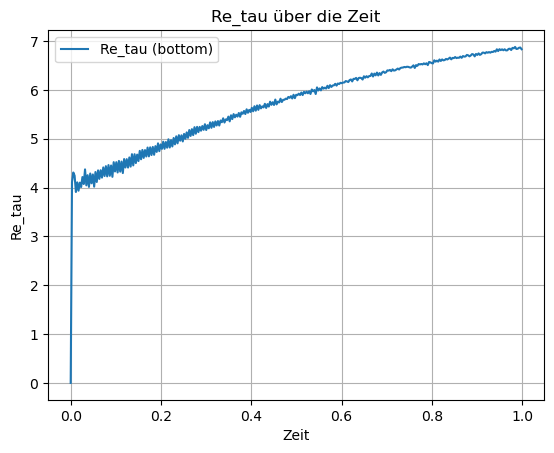

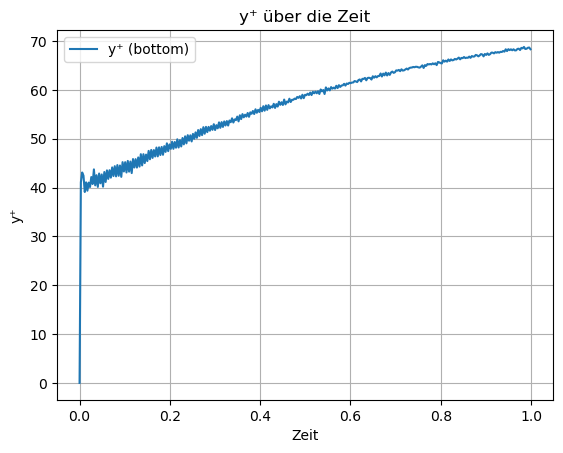

In [9]:
import matplotlib.pyplot as plt
import numpy as np


print(wq_bottom)
# Beispiel: Daten laden
data = (wq_bottom_arr+wq_top_arr)/2
time = data[:, 1]
re_tau = data[:, 3]
y_plus = data[:, 4]


plt.figure()
plt.plot(time, re_tau, label="Re_tau (bottom)")
plt.xlabel("Zeit")
plt.ylabel("Re_tau")
plt.legend()
plt.grid()
plt.title("Re_tau über die Zeit")
plt.savefig(csvdir + "retau.pdf")

plt.show()

plt.figure()
plt.plot(time, y_plus, label="y⁺ (bottom)")
plt.xlabel("Zeit")
plt.ylabel("y⁺")
plt.legend()
plt.grid()
plt.title("y⁺ über die Zeit")
plt.savefig(csvdir + "yplus.pdf")
plt.show()
